In [43]:
# Importing necessary libraries
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools  # Used for iterating and looping
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    f1_score
)

from imblearn.over_sampling import RandomOverSampler  # Type: ignore
from accelerate import Accelerator
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTForImageClassification,
    ViTImageProcessor,
    DefaultDataCollator
)

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (  # For image transformation
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to an image
    RandomResizedCrop,  # Apply random resized crop to an image
    RandomHorizontalFlip,  # Apply random horizontal flip to an image
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize an image to a given size
    ToTensor  # Convert image to tensor
)


In [44]:
from PIL import ImageFile

#this allows the pil library to load truncated images(corrupted or incomplete images)
ImageFile.LOAD_TRUNCATED_IMAGES = True  

In [45]:
from pathlib import Path

file_names = [] 
labels = []

dataset_path = r"C:\Users\anant\Downloads\Dataset"

for file in sorted(Path(dataset_path).glob('*/*/*.*')):  
    label = file.parent.name 
    labels.append(label)
    file_names.append(str(file))
    # print(file, label) 

print(len(file_names), len(labels))  

df = pd.DataFrame.from_dict({"image": file_names, "label": labels})  # Create DataFrame from file names and labels
print(df.shape)

df.head()


6006 6006
(6006, 2)


,image,label
0,C:\Users\anant\Downloads\Dataset\Test\Fake\fak...,Fake
1,C:\Users\anant\Downloads\Dataset\Test\Fake\fak...,Fake
2,C:\Users\anant\Downloads\Dataset\Test\Fake\fak...,Fake
3,C:\Users\anant\Downloads\Dataset\Test\Fake\fak...,Fake
4,C:\Users\anant\Downloads\Dataset\Test\Fake\fak...,Fake


In [46]:
df["label"].unique()

array(['Fake', 'Real'], dtype=object)

In [47]:
from collections import Counter

original_counts = Counter(labels)
print("Before Oversampling:", original_counts)

Before Oversampling: Counter({'Fake': 3003, 'Real': 3003})


In [48]:
y = df[['label']]

# print(y)
# print(y.shape)

df = df.drop(columns=['label'] , axis=1)

ros = RandomOverSampler(random_state=83)

df , y_resampled = ros.fit_resample(df, y) 

del y

df['label'] = y_resampled

gc.collect()

print(df.shape)

new_counts = Counter(df['label'])
print("After Oversampling:", new_counts)

for label in original_counts:
    if new_counts[label] > original_counts[label]:
        print(f"Class '{label}' increased by {new_counts[label] - original_counts[label]} samples")


  0%|          | 4/1162 [10:30<50:41:09, 157.57s/it]

(6006, 2)
After Oversampling: Counter({'Fake': 3003, 'Real': 3003})


In [49]:
# to convert the dataset into huggingface dataset format
dataset = Dataset.from_pandas(df).cast_column("image", Image())  

Fake


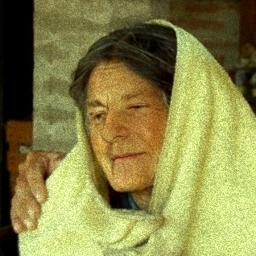

In [50]:
print(dataset[0]["label"])
dataset[0]["image"]  


In [51]:
labels_subset = labels[:10]  
print(labels_subset)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [52]:
labels_list = ['Real','Fake']

label_to_id , id_to_label = dict() , dict() 

for i,label in enumerate(labels_list):
    label_to_id[label] = i
    id_to_label[i] = label

print(label_to_id)
print(id_to_label)


{'Real': 0, 'Fake': 1}
{0: 'Real', 1: 'Fake'}


Casting the dataset: 100%|██████████| 6006/6006 [00:00<00:00, 1534445.38 examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3603
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2403
    })
})


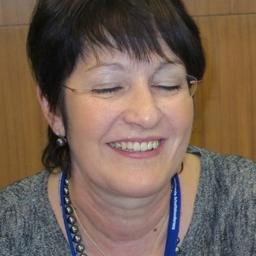

In [53]:
class_label = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_labels_to_id(exam):
    if isinstance(exam['label'], str):  
        exam['label'] = class_label.str2int(exam['label'])  
    return exam

dataset = dataset.map(map_labels_to_id)

dataset = dataset.cast_column("label", class_label)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset["train"]
test_data = dataset["test"]

print(dataset)

# print(train_data)
# print(test_data)
# train_data[0]
# test_data[0]
train_data[0]["image"]
# print(train_data[0]["label"])
test_data[0]["image"]
# print(test_data[0]["label"])



In [ ]:
model_str = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_str)

# Get image normalization details
image_mean, image_std = processor.image_mean, processor.image_std
size = (processor.size["height"], processor.size["width"])  

print("Image size:", size)
print("Image mean and std:", image_mean, image_std)

# Define transformations
normalize = Normalize(mean=image_mean, std=image_std)

_train_transform = Compose([
    Resize(size), 
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize
])

_val_tranforms = Compose([
    Resize(size),  
    ToTensor(),
    normalize
])

# Train transforms
def train_tranforms(examples):
    examples["pixel_values"] = [_train_transform(image.convert("RGB")) for image in examples["image"]]
    return examples

# Validation transforms
def val_tranforms(examples):
    examples["pixel_values"] = [_val_tranforms(image.convert("RGB")) for image in examples["image"]]
    return examples

Image size: (224, 224)
Image mean and std: [0.5, 0.5, 0.5] [0.5, 0.5, 0.5]


In [55]:
train_data.set_transform(train_tranforms)  

test_data.set_transform(val_tranforms)

In [56]:
def collate_func(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels} 


Load Train and evaluate model



In [57]:
model = ViTForImageClassification.from_pretrained(
    model_str,
    num_labels=len(labels_list),
)

model.config.label2id = label_to_id
model.config.id2label = id_to_label

print(model.num_parameters(only_trainable=True) / 1e6) 

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [58]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)["accuracy"]

    return {
        "accuracy": acc_score,
    }


In [59]:
metric_name = "accuracy"
model_name = "vit-base-patch16-224-in21k"

num_train_epochs = 2 

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02, 
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [60]:
trainer = Trainer(
    model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_func,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [61]:
trainer.train()

 50%|█████     | 113/226 [22:48<19:54, 10.57s/it]












































































































































































































































































































                                                 

                                           
 50%|█████     | 113/226 [27:09<19:54, 10.57s/it]



{'eval_loss': 0.6840665936470032, 'eval_accuracy': 0.5713691219309197, 'eval_runtime': 261.2718, 'eval_samples_per_second': 9.197, 'eval_steps_per_second': 1.152, 'epoch': 1.0}


100%|██████████| 226/226 [49:02<00:00, 10.37s/it]  











































































































































































































































































































                                                 

                                           
100%|██████████| 226/226 [52:58<00:00, 10.37s/it]



{'eval_loss': 0.6806446313858032, 'eval_accuracy': 0.5975863503953391, 'eval_runtime': 235.589, 'eval_samples_per_second': 10.2, 'eval_steps_per_second': 1.278, 'epoch': 2.0}


                                                 
100%|██████████| 226/226 [53:01<00:00, 14.08s/it]

{'train_runtime': 3181.4778, 'train_samples_per_second': 2.265, 'train_steps_per_second': 0.071, 'train_loss': 0.6825255672488593, 'epoch': 2.0}


TrainOutput(global_step=226, training_loss=0.6825255672488593, metrics={'train_runtime': 3181.4778, 'train_samples_per_second': 2.265, 'train_steps_per_second': 0.071, 'train_loss': 0.6825255672488593, 'epoch': 2.0})

In [62]:
trainer.evaluate()

100%|██████████| 301/301 [02:49<00:00,  1.78it/s]


{'eval_loss': 0.6806446313858032,
 'eval_accuracy': 0.5975863503953391,
 'eval_runtime': 169.9621,
 'eval_samples_per_second': 14.138,
 'eval_steps_per_second': 1.771,
 'epoch': 2.0}

In [63]:
outputs = trainer.predict(test_data)

print(outputs.metrics)

100%|██████████| 301/301 [02:57<00:00,  1.70it/s]

{'test_loss': 0.6806446313858032, 'test_accuracy': 0.5975863503953391, 'test_runtime': 178.6887, 'test_samples_per_second': 13.448, 'test_steps_per_second': 1.684}


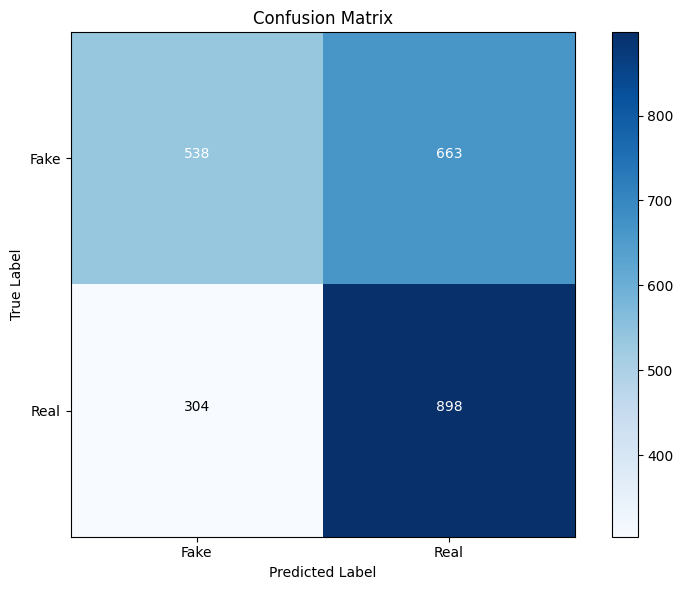

Accuracy: 0.5975863503953391
F1 Score: 0.5883472762320212

Classification Report

              precision    recall  f1-score   support

        Fake     0.6390    0.4480    0.5267      1201
        Real     0.5753    0.7471    0.6500      1202

    accuracy                         0.5976      2403
   macro avg     0.6071    0.5975    0.5883      2403
weighted avg     0.6071    0.5976    0.5884      2403



<Figure size 640x480 with 0 Axes>

In [ ]:
y_true = np.array(outputs.label_ids)
y_pre = np.array(outputs.predictions).argmax(1)

labels_list = ["Fake", "Real"]  

def plot_confusion_matrix(cm, classes, title="Confusion Matrix", cmap=plt.cm.Blues, figsize=(8,6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show(block=False)  
    plt.savefig("confusion_matrix.png")  

cm = confusion_matrix(y_true, y_pre, labels=[0, 1]) 

plot_confusion_matrix(cm, labels_list, figsize=(8,6))

accuracy = accuracy_score(y_true, y_pre)
f1 = f1_score(y_true, y_pre, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("\nClassification Report\n")
print(classification_report(y_true, y_pre, target_names=labels_list, digits=4))

In [72]:
trainer.save_model()

In [79]:
from transformers import pipeline

pipe = pipeline('image-classification' , model=model_name ,device=0)

In [82]:
from PIL import Image

image_path = r"C:\Users\anant\Desktop\DEEPFAKE MODEL\Dataset\Test\Fake\fake_0.jpg" 

image = Image.open(image_path).convert("RGB")

result = pipe(image)

print(result)


[{'label': 'Fake', 'score': 0.5046415328979492}, {'label': 'Real', 'score': 0.495358407497406}]
